# SIT744 Practical 9: ResNet
 

*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>


## Pre-practical readings

- [Writing custom layers and models with Keras](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

By now you should be familiar with the classical ConvNet architectures. In this practical, you will practice building deep models with more layers using residual units.



## Task 1 Keras ImageDataGenerator

We will continue using the *cats vs dogs* dataset in this practical. This time, we will be more serious about data augmentation by using Keras's `ImageDataGenerator`. This allows us to use a variety of predefined types of data augmentation. For this to work, we have to organise training and test images into folders.


In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()





--2022-05-06 06:13:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.214.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   172MB/s    in 0.4s    

2022-05-06 06:13:14 (172 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Take a look into the folder `/tmp/cats_and_dogs_filtered` and see how the images are organised.

In [2]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

`ImageDataGenerator` contains a collection of data augmentation operations. It works with the function `flow_from_directory` to create an input pipeline.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SIZE = 150
BATCH_SIZE = 32

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to 150x150
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_generator

**exercise** Read the documentation for `ImageDataGenerator` and understand what data-augmentation operations are defined. Experiment with different configurations and see what each data augmentation does.


## Task 2 ResNet

We have seen VGG in the last two weeks. VGG has a very classical ConvNet architecture. Compared with VGG, ResNets can go much deeper, achieve a much higher classification accuracy, and is easier to train. Moreover, ResNets have a surprisingly simple architecture. At the centre is a repetition of multiple **residual units**.

A ResNet contains two types of residual units, depending on whether subsampling happens (stride>1).
![Residual units (src: d2l)](https://d2l.ai/_images/resnet-block.svg)

Subsampling happens at the first of the two convolutional layers. When the first convolutional layer has stride 1, the skip connection is just a pass-through. Otherwise, the skip connection is replaced with a 1x1 convolution layer of the matching stride setting (Note that this is no longer an identity mapping).


### Write custom layers

Here we define a ResidualUnit layer subclassing `keras.layers.Layer`. A layer defines a transformation from the input to the output, parametrised by the layer weights.

In [5]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", 
                        use_bias=False,
                        kernel_regularizer=keras.regularizers.l2(0.01)
                        )

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

### Write the custom model

Now we have a custom layer for the residual unit. We will build a relatively shallow ResNet.

In [6]:
model = keras.models.Sequential()

prev_filters = 64
c = [prev_filters, 2*prev_filters, 4*prev_filters, 4*prev_filters]
model.add(DefaultConv2D(c[0], 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
model.add(ResidualUnit(c[0], strides=1))
model.add(ResidualUnit(c[1], strides=2))
model.add(ResidualUnit(c[2], strides=2))
model.add(ResidualUnit(c[3], strides=2))
model.add(keras.layers.MaxPool2D(pool_size=(4, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1728      
                                                                 
 residual_unit (ResidualUnit  (None, 150, 150, 64)     74240     
 )                                                               
                                                                 
 residual_unit_1 (ResidualUn  (None, 75, 75, 128)      230912    
 it)                                                             
                                                                 
 residual_unit_2 (ResidualUn  (None, 38, 38, 256)      920576    
 it)                                                             
                                                                 
 residual_unit_3 (ResidualUn  (None, 19, 19, 256)      1248256   
 it)                                                    

### Train the model

Training will be just like for any Keras model. Because our input data is from a Keras input pipeline (generator), we have to specify how many steps per epoch.  

In [7]:
%%time 

from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])


history = model.fit(
    train_generator,
    # steps_per_epoch=100,
    steps_per_epoch =2000//BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    # validation_steps=50
    validation_steps=1000//BATCH_SIZE
    )

Epoch 1/30
62/62 [==============================] - 41s 398ms/step - loss: 18.6452 - acc: 0.5833 - val_loss: 18.2781 - val_acc: 0.5020
Epoch 2/30
62/62 [==============================] - 23s 373ms/step - loss: 18.1905 - acc: 0.6032 - val_loss: 17.9165 - val_acc: 0.4970
Epoch 3/30
62/62 [==============================] - 23s 364ms/step - loss: 17.7332 - acc: 0.6042 - val_loss: 17.5538 - val_acc: 0.5020
Epoch 4/30
62/62 [==============================] - 23s 369ms/step - loss: 17.2096 - acc: 0.6260 - val_loss: 17.0684 - val_acc: 0.5060
Epoch 5/30
62/62 [==============================] - 23s 373ms/step - loss: 16.6749 - acc: 0.6347 - val_loss: 16.6518 - val_acc: 0.5050
Epoch 6/30
62/62 [==============================] - 23s 373ms/step - loss: 16.0573 - acc: 0.6514 - val_loss: 15.7542 - val_acc: 0.6028
Epoch 7/30
62/62 [==============================] - 23s 370ms/step - loss: 15.4635 - acc: 0.6433 - val_loss: 15.1769 - val_acc: 0.6210
Epoch 8/30
62/62 [==============================] - 25s

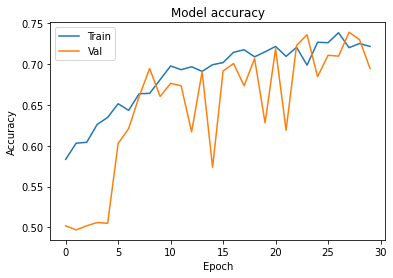

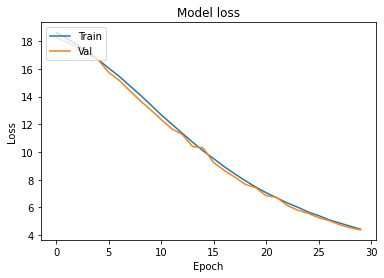

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**exercise** Try a different batch size. See if it affects the model performance and the training speed.

## Task 3 Depth Separable Convolution

In the lecture, we see that Depth Separable Convolution can be used to reduce the number of training parameters. We will explore the potential benefit of using depth separable convolution layers in a residual unit.

In [9]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", 
                        use_bias=False,
                        kernel_regularizer=keras.regularizers.l2(0.01)
                        )
#not do weighted summation
DefaultSeparableConv2D = partial(keras.layers.SeparableConv2D, kernel_size=3, strides=1,
                                 padding="SAME", 
                                 use_bias=False,
                                 depth_multiplier=2,
                                 kernel_regularizer=keras.regularizers.l2(0.01))
#depth_multiplier
class DepthwiseResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultSeparableConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultSeparableConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = keras.models.Sequential()

prev_filters = 64
c = [prev_filters, 2*prev_filters, 4*prev_filters, 4*prev_filters]
model.add(DefaultConv2D(c[0], 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
model.add(DepthwiseResidualUnit(c[0], strides=1))
model.add(DepthwiseResidualUnit(c[1], strides=2))
model.add(DepthwiseResidualUnit(c[2], strides=2))
model.add(DepthwiseResidualUnit(c[3], strides=2))
model.add(keras.layers.MaxPool2D(pool_size=(4, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))



In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 64)      1728      
                                                                 
 depthwise_residual_unit (De  (None, 150, 150, 64)     19200     
 pthwiseResidualUnit)                                            
                                                                 
 depthwise_residual_unit_1 (  (None, 75, 75, 128)      62336     
 DepthwiseResidualUnit)                                          
                                                                 
 depthwise_residual_unit_2 (  (None, 38, 38, 256)      239360    
 DepthwiseResidualUnit)                                          
                                                                 
 depthwise_residual_unit_3 (  (None, 19, 19, 256)      339968    
 DepthwiseResidualUnit)                               

**question** How does the number of parameters change with the introduction of separable convolution layers?

In [11]:
%%time 

from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


# history = model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=30,
#     validation_data=validation_generator,
#     validation_steps=50)



history = model.fit(
    train_generator,
    # steps_per_epoch=100,
    steps_per_epoch =2000//BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    # validation_steps=50
    validation_steps=1000//BATCH_SIZE
    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
62/62 [==============================] - 42s 630ms/step - loss: 5.9534 - acc: 0.5493 - val_loss: 5.7703 - val_acc: 0.5020
Epoch 2/30
62/62 [==============================] - 40s 636ms/step - loss: 5.7646 - acc: 0.5920 - val_loss: 5.6531 - val_acc: 0.5010
Epoch 3/30
62/62 [==============================] - 37s 596ms/step - loss: 5.6299 - acc: 0.6291 - val_loss: 5.5367 - val_acc: 0.4909
Epoch 4/30
62/62 [==============================] - 37s 597ms/step - loss: 5.5102 - acc: 0.6159 - val_loss: 5.4249 - val_acc: 0.5010
Epoch 5/30
62/62 [==============================] - 38s 604ms/step - loss: 5.3470 - acc: 0.6468 - val_loss: 5.3093 - val_acc: 0.4849
Epoch 6/30
62/62 [==============================] - 37s 595ms/step - loss: 5.2475 - acc: 0.6316 - val_loss: 5.2030 - val_acc: 0.4960
Epoch 7/30
62/62 [==============================] - 37s 601ms/step - loss: 5.1016 - acc: 0.6570 - val_loss: 5.0969 - val_acc: 0.4990
Epoch 8/30
62/62 [==============================] - 37s 588ms/step - 

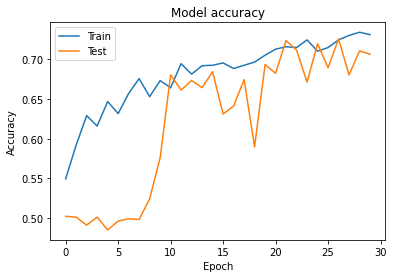

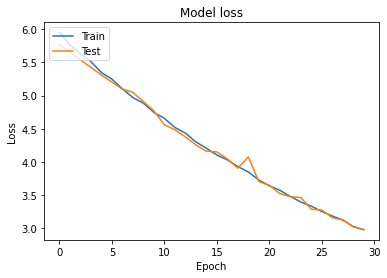

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**question** Do you see any performance improvement by using separable convolution layers? How about the difference in the training time?

**exercise** Continue the training of the above two models until they converge. What validation accuracy can you achieve?

## Additional resources

- David Page has authored a wonderful series of articles on [practical tips for training ResNets.](https://myrtle.ai/how-to-train-your-resnet/)